In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/MasterResearch

/content/drive/MyDrive/MasterResearch


In [3]:
from torch import optim, cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


In [4]:
base_dir = "./images"
TEST = 19
default_image_size = tuple((224, 224))
width=224
height=224
depth=3
EPOCHS = 7
INIT_LR = 1e-3
BS = 64

In [5]:
import keras
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import pickle
import os
import pandas as pd
from os import listdir
import shutil
import os.path
import cv2
from keras.preprocessing.image import img_to_array
import math
import numpy as np
from IPython.display import SVG
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from shutil import copyfile
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
data = []
for folder in sorted(os.listdir(base_dir)):
    for file in sorted(os.listdir(base_dir+"/"+folder)):
        data.append((folder, file))

df = pd.DataFrame(data, columns=['Folder', 'File'])


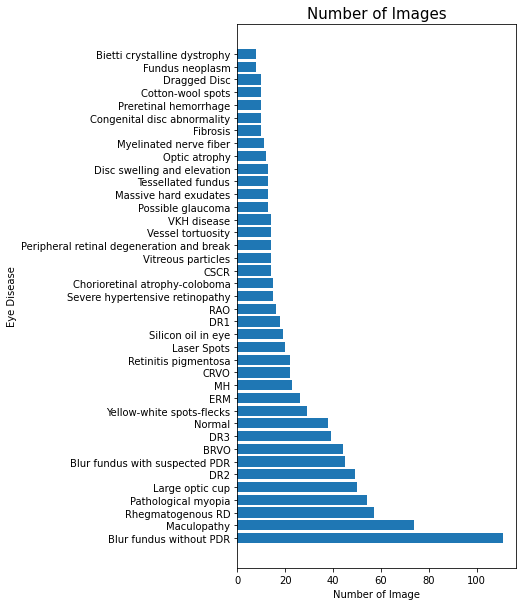

In [ ]:

counts = df['Folder'].value_counts()
plt.figure(figsize=(5,10))
ax = plt.barh(counts.index,counts.values)
#             , title="Number of Images" )
plt.title('Number of Images', fontsize=15)
plt.ylabel("Eye Disease")
plt.xlabel("Number of Image")
plt.show()

In [ ]:


# Add Lighting to the images for improving the visibility 

def draw_img_light(img, sigmaX=10):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128) # the trick is to add this line
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [ ]:
def image_resize(image_path, dim):
  img = cv2.imread(image_path)
  if img.shape[1] != img.shape[0]:
    x = img.shape[1]//2
    y = img.shape[0]//2
    x = x-y
    img = img[0:0+img.shape[0], x:x+img.shape[0]]
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  
def clahe(image_path, denoise=False, limit=None):
    bgr = cv2.imread(image_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(16,32))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr
    
def hist_eq(img):
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_y_cr_cb)
    img_eq = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((img_eq, cr, cb))
    img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)
    #img=cv2.addWeighted (img_rgb_eq,4, cv2.GaussianBlur( img_rgb_eq , (0,0) , 224/10) ,-4 ,128) # the trick is to add this line 
    return img_rgb_eq


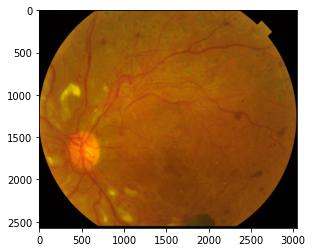

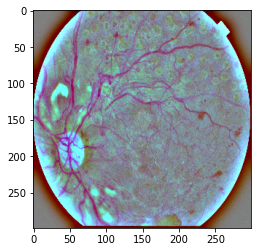

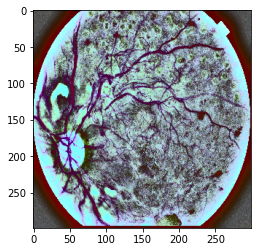

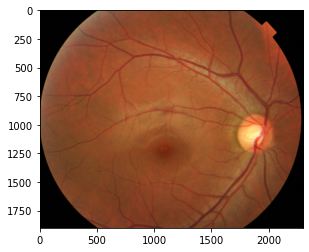

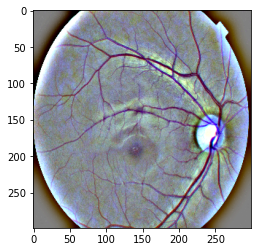

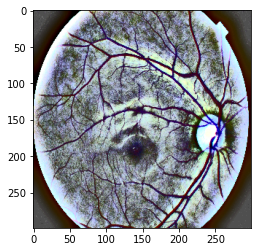

In [ ]:
img_file = './images/DR3/1ffa92e5-8d87-11e8-9daf-6045cb817f5b..JPG'

image = cv2.imread(img_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

plt.imshow(draw_img_light(image))
plt.show()

plt.imshow(hist_eq(draw_img_light(image)))
plt.show()

img_file = './images/Large optic cup/1ffa94d0-8d87-11e8-9daf-6045cb817f5b..JPG'
image = cv2.imread(img_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()
plt.imshow(draw_img_light(image))
plt.show()
plt.imshow(hist_eq(draw_img_light(image)))
plt.show()


In [ ]:
def check_images(image_dir, output_home):
  image_list, label_list = [], [] 
  Total = 0
  Removed_folder = 0
  Kept_folder = 0 
  if os.path.isdir(output_home):
      shutil.rmtree(output_home, ignore_errors=True)
      print("Directory '%s' has been removed successfully" %output_home) 
  if not os.path.isdir(output_home):
      os.mkdir(output_home)
      print("Directory '%s' has been created successfully" %output_home) 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      Total = len(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          eye_images = len(eye_disease_image_list)
          if eye_images > 19:
              Kept_folder = Kept_folder + 1
              print("Keeping Folder: {}".format(disease_folder))
              for single_eye_disease_image in eye_disease_image_list :
                  if single_eye_disease_image == ".DS_Store" :
                      eye_disease_image_list.remove(single_eye_disease_image)
                  else:
                      image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                      if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                          #print(image_directory)
                          output_dir = f"{output_home}/{disease_folder}"
                          if not os.path.isdir(output_dir):
                              os.mkdir(output_dir)
                          output_file = os.path.join(output_dir, single_eye_disease_image)
                          copyfile(image_directory, output_file)
          else:
              Removed_folder = Removed_folder + 1
              print("Removing Folder: {} as it has {} images".format(disease_folder, eye_images))
      print("\n \n Out of Total:{} kept {} and removed {} directory".format(Total, Kept_folder, Removed_folder))

      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")

In [ ]:



base_dir_mod = base_dir + "_test"
check_images(base_dir,base_dir_mod)

Directory './images_test' has been removed successfully
Directory './images_test' has been created successfully
[INFO] Loading images ...
Keeping Folder: BRVO
Keeping Folder: CRVO
Removing Folder: Chorioretinal atrophy-coloboma as it has 15 images
Removing Folder: Cotton-wool spots as it has 10 images
Removing Folder: Congenital disc abnormality as it has 10 images
Keeping Folder: Blur fundus without PDR
Keeping Folder: Blur fundus with suspected PDR
Removing Folder: CSCR as it has 14 images
Removing Folder: Disc swelling and elevation as it has 13 images
Removing Folder: Bietti crystalline dystrophy as it has 8 images
Keeping Folder: DR3
Keeping Folder: DR2
Removing Folder: Dragged Disc as it has 10 images
Keeping Folder: Large optic cup
Keeping Folder: ERM
Keeping Folder: Laser Spots
Keeping Folder: Maculopathy
Removing Folder: DR1 as it has 18 images
Removing Folder: Fibrosis as it has 10 images
Removing Folder: Fundus neoplasm as it has 8 images
Keeping Folder: Normal
Removing Fold

In [ ]:




data = []
for folder in sorted(os.listdir(base_dir_mod)):
    for file in sorted(os.listdir(base_dir_mod+"/"+folder)):
        data.append((folder, file))

df = pd.DataFrame(data, columns=['Folder', 'File'])

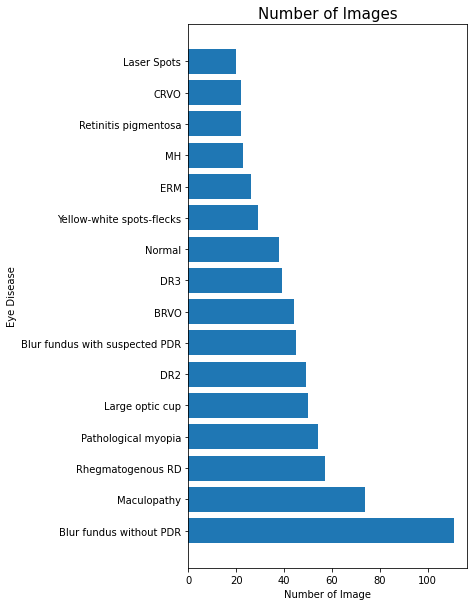

In [ ]:
counts = df['Folder'].value_counts()
plt.figure(figsize=(5,10))
ax = plt.barh(counts.index,counts.values)
#             , title="Number of Images" )
plt.title('Number of Images', fontsize=15)
plt.ylabel("Eye Disease")
plt.xlabel("Number of Image")
plt.show()

In [ ]:
#define croping function with tensorflow resize
def crop_image(image_path):
  image_data = tf.keras.preprocessing.image.load_img(image_path)
  
  array = tf.keras.preprocessing.image.img_to_array(image_data)
  image = tf.image.resize(
                        array, [224,224], 
                        method='bilinear',
                        preserve_aspect_ratio=True,
                        antialias=False,
                        )
  # image = image / 255.0
  return image

In [ ]:
def print_image(path, file_path):
    source = path + '/' + file_path
    test = crop_image(source)
    test = np.array(test)
    img = tf.keras.preprocessing.image.array_to_img(test)
    plt.imshow(img)
    test = np.expand_dims(test, axis=0)
    test.shape
    return None


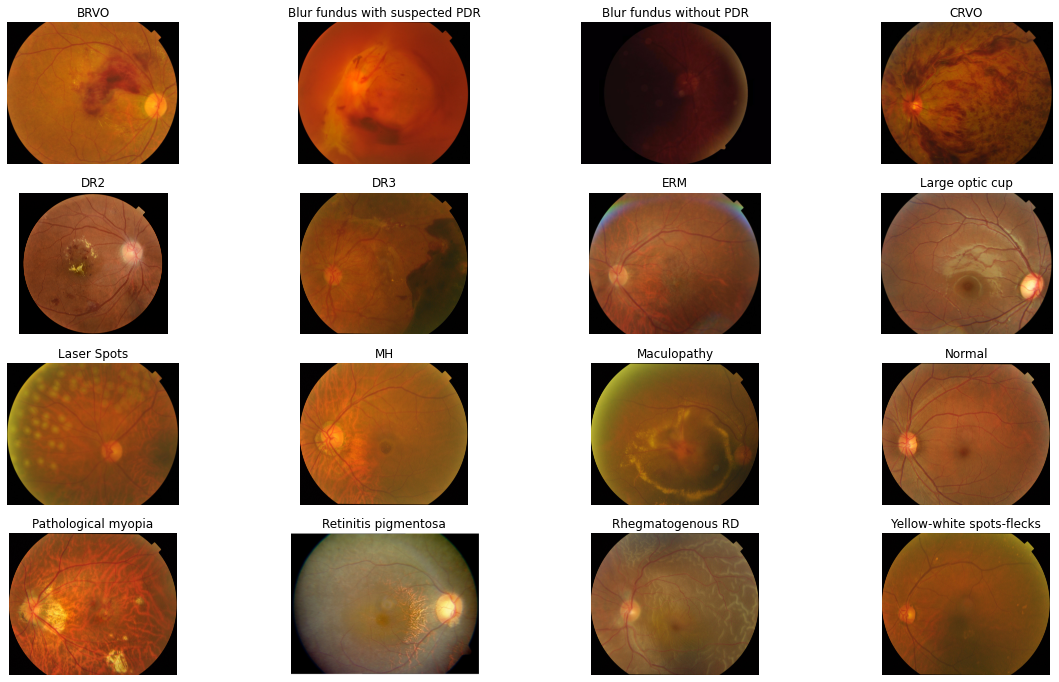

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
        #test.shape
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()

    
    



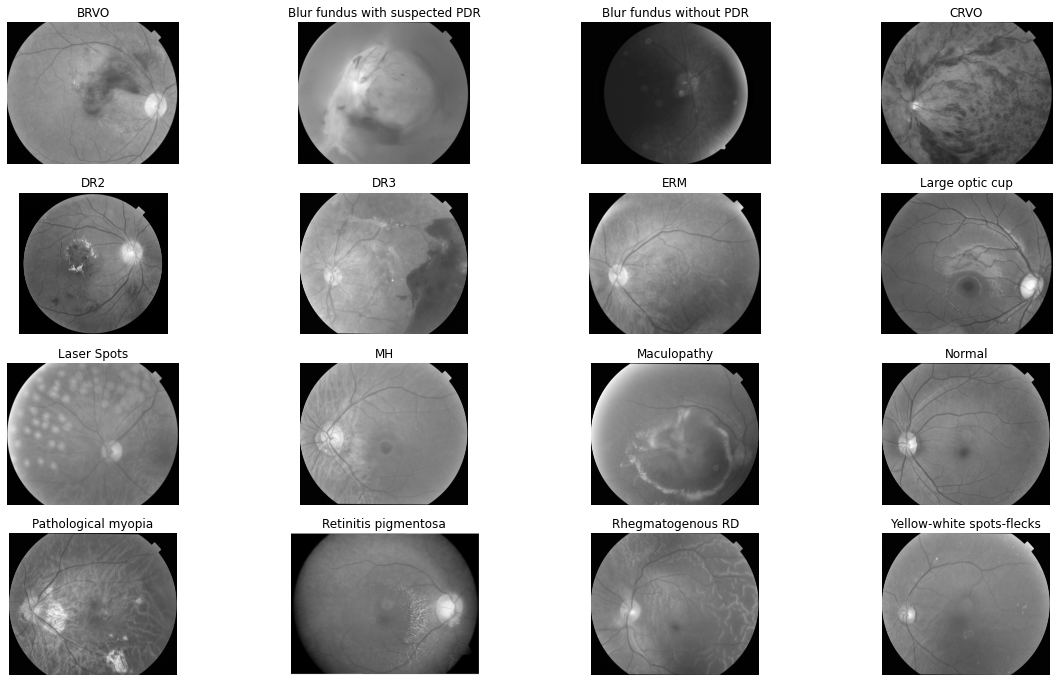

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image, cmap='gray')
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image


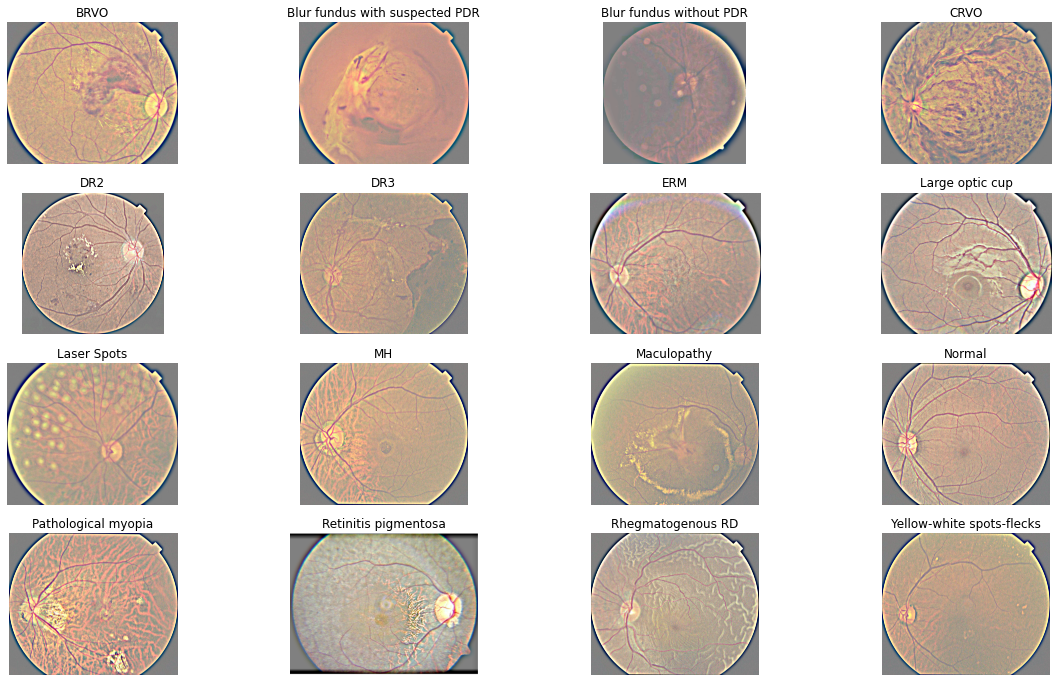

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = load_ben_color(source,sigmaX=30)
        #image = cv2.imread(source)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image, cmap='gray')
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
#        test.shape
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
def convert_image_to_array(image_dir, default_image_size):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :", e)
        return None

In [ ]:
def load_images(image_dir, default_image_size):
  image_list, label_list = [], [] 
  Total = 0
  Removed_folder = 0
  Kept_folder = 0 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      Total = len(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          eye_images = len(eye_disease_image_list)
          print(f"[INFO] Processing {disease_folder} ...")
          for single_eye_disease_image in eye_disease_image_list :
              if single_eye_disease_image == ".DS_Store" :
                  eye_disease_image_list.remove(single_eye_disease_image)
              else:
                  image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                  if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                      #print(image_directory)
                      image_list.append(convert_image_to_array(image_directory, default_image_size))
                      label_list.append(disease_folder)
                                
      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")
  return image_list, label_list

In [ ]:
image_list, label_list = load_images(base_dir_mod, default_image_size)

[INFO] Loading images ...
[INFO] Processing BRVO ...
[INFO] Processing CRVO ...
[INFO] Processing Blur fundus without PDR ...
[INFO] Processing Blur fundus with suspected PDR ...
[INFO] Processing DR3 ...
[INFO] Processing DR2 ...
[INFO] Processing Large optic cup ...
[INFO] Processing ERM ...
[INFO] Processing Laser Spots ...
[INFO] Processing Maculopathy ...
[INFO] Processing Normal ...
[INFO] Processing MH ...
[INFO] Processing Pathological myopia ...
[INFO] Processing Retinitis pigmentosa ...
[INFO] Processing Yellow-white spots-flecks ...
[INFO] Processing Rhegmatogenous RD ...
[INFO] Image loading completed


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(image_labels)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
print(label_binarizer.classes_)

['BRVO' 'Blur fundus with suspected PDR' 'Blur fundus without PDR' 'CRVO'
 'DR2' 'DR3' 'ERM' 'Large optic cup' 'Laser Spots' 'MH' 'Maculopathy'
 'Normal' 'Pathological myopia' 'Retinitis pigmentosa' 'Rhegmatogenous RD'
 'Yellow-white spots-flecks']


In [ ]:
#--np_image_list = np.array(image_list, dtype=np.float16) / 255.0
#--print("[INFO] Spliting data to train, test")
#--x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 64)

In [ ]:
def load_ben_color_img(image, sigmaX=10):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [ ]:
def convert(image_dir, output_home, limit=None):
  image_list, label_list = [], []
  if os.path.isdir(output_home):
      shutil.rmtree(output_home, ignore_errors=True)
      print("Directory '%s' has been removed successfully" %output_home) 
  if not os.path.isdir(output_home):
      os.mkdir(output_home)
      print("Directory '%s' has been created successfully" %output_home) 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      print(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          print(eye_disease_image_list)
          for single_eye_disease_image in eye_disease_image_list :
              if single_eye_disease_image == ".DS_Store" :
                  eye_disease_image_list.remove(single_eye_disease_image)
              else:
                  image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                  if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                      print(image_directory)
                    
                      bgr = clahe(image_directory, limit=limit)
                      bgr = hist_eq(bgr)
                      #bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                      
                      #green_image = bgr.copy()
                      #green_image[:,:,0] = 0
                      #green_image[:,:,2] = 0
                      #bgr = green_image
                      #bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                      #bgr = load_ben_color_img(bgr,sigmaX=30)
                      bgr = crop_image_from_gray(bgr)


                      output_dir = f"{output_home}/{disease_folder}"
                      if not os.path.isdir(output_dir):
                          os.mkdir(output_dir)
                      output_file = os.path.join(output_dir, single_eye_disease_image)
                      cv2.imwrite(output_file, bgr)

      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")

In [ ]:
base_dir_mod
output_home_dir = "./images_modified_224"
limit = 2.0
convert(base_dir_mod, output_home_dir, limit=limit)

Directory './images_modified' has been removed successfully
Directory './images_modified' has been created successfully
[INFO] Loading images ...
['BRVO', 'CRVO', 'Blur fundus without PDR', 'Blur fundus with suspected PDR', 'DR3', 'DR2', 'Large optic cup', 'ERM', 'Laser Spots', 'Maculopathy', 'Normal', 'MH', 'Pathological myopia', 'Retinitis pigmentosa', 'Yellow-white spots-flecks', 'Rhegmatogenous RD']
['1ffa95f2-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f4-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f3-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9611-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa960f-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95fb-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9606-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95fd-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9601-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9608-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9604-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9603-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa96

In [ ]:
base_dir = "./images_modified_224"

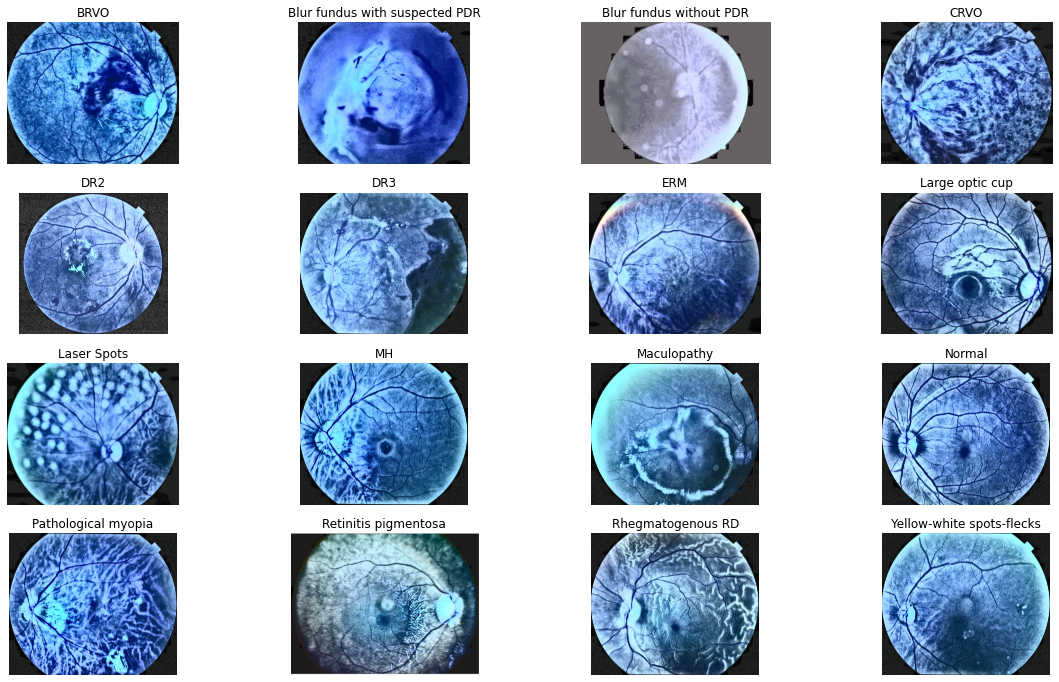

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        #image = load_ben_color(source,sigmaX=30)
        image = cv2.imread(source)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image)
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)

        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
#np_image_list = np.array(image_list, dtype=np.float16) / 255.0
#train_x, valid_x, train_y, valid_y = train_test_split(np_image_list, image_labels, test_size=0.20,
#                                                      stratify=y, random_state=2021)
#print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)


In [6]:
base_dir = "./images_modified_224"
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = keras.preprocessing.image.ImageDataGenerator(      rescale = 1/255.0,
                                                            rotation_range=45,
                                                             shear_range = 0.1,
                                                             zoom_range = 0.2,
                                                            brightness_range=[0.2,1.0],
                                                             horizontal_flip=True,
                                                             vertical_flip=True,
                                                             dtype=np.float32,
                                                            validation_split = 0.2,
                                                             fill_mode='constant'
                                                             )


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#train_generator = datagen.flow(train_x, train_y, batch_size=BATCH_SIZE)
#val_generator = datagen.flow(valid_x, valid_y, batch_size=BATCH_SIZE)


Found 570 images belonging to 16 classes.
Found 133 images belonging to 16 classes.


In [7]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 16))

In [8]:
Diseases = list(train_generator.class_indices.keys())
print(Diseases)

['BRVO', 'Blur fundus with suspected PDR', 'Blur fundus without PDR', 'CRVO', 'DR2', 'DR3', 'ERM', 'Large optic cup', 'Laser Spots', 'MH', 'Maculopathy', 'Normal', 'Pathological myopia', 'Retinitis pigmentosa', 'Rhegmatogenous RD', 'Yellow-white spots-flecks']


In [9]:
Diseases = list(train_generator.class_indices.keys())
print(Diseases)

['BRVO', 'Blur fundus with suspected PDR', 'Blur fundus without PDR', 'CRVO', 'DR2', 'DR3', 'ERM', 'Large optic cup', 'Laser Spots', 'MH', 'Maculopathy', 'Normal', 'Pathological myopia', 'Retinitis pigmentosa', 'Rhegmatogenous RD', 'Yellow-white spots-flecks']


In [10]:
# Number of images for each disease
nums = {}
for disease in Diseases:
    nums[disease] = len(os.listdir(base_dir + '/' + disease))
print(nums)

{'BRVO': 44, 'Blur fundus with suspected PDR': 45, 'Blur fundus without PDR': 111, 'CRVO': 22, 'DR2': 49, 'DR3': 39, 'ERM': 26, 'Large optic cup': 50, 'Laser Spots': 20, 'MH': 23, 'Maculopathy': 74, 'Normal': 38, 'Pathological myopia': 54, 'Retinitis pigmentosa': 22, 'Rhegmatogenous RD': 57, 'Yellow-white spots-flecks': 29}


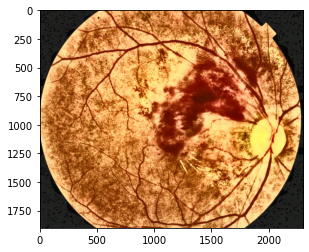

In [11]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
# Take one image to visualize it's changes after every layer
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('./images_modified_224/BRVO/1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG')
plt.imshow(img1);

#preprocess image
img1 = image.load_img('./images_modified_224/BRVO/1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG', target_size=(IMAGE_SIZE, IMAGE_SIZE))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [ ]:
def get_model_densenet():
  base_model = DenseNet121(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
#SVG(tf.keras.utils.model_to_dot(model, dpi=70, show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, subgraph=False).create(prog='dot', format='svg'))

In [13]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
    
)



Epoch 1/50
18/18 [==============================] - 91s 5s/step - loss: 3.1200 - accuracy: 0.1045 - val_loss: 2.3926 - val_accuracy: 0.3008
Epoch 2/50
18/18 [==============================] - 77s 4s/step - loss: 2.3151 - accuracy: 0.3096 - val_loss: 2.0635 - val_accuracy: 0.4135
Epoch 3/50
18/18 [==============================] - 78s 4s/step - loss: 2.1546 - accuracy: 0.3169 - val_loss: 1.8485 - val_accuracy: 0.4662
Epoch 4/50
 3/18 [====>.........................] - ETA: 50s - loss: 1.9896 - accuracy: 0.3127

KeyboardInterrupt: ignored

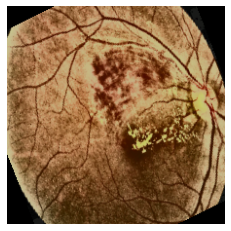

True label: BRVO
Predicted label: Maculopathy


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in val_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(val_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('densenet_adam.h5')

Test loss: 0.5676811337471008
Test Accuracy: 0.8120300769805908


In [12]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)

Confusion Matrix
[[0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0]
 [0 0 1 0 1 2 1 1 0 0 2 1 0 0 0 0]
 [0 1 3 2 4 0 0 1 1 2 3 2 0 0 2 1]
 [0 0 0 0 2 0 0 0 1 0 0 0 1 0 0 0]
 [0 3 0 0 1 0 1 0 0 0 1 0 1 1 1 0]
 [0 1 4 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 2 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [2 0 0 0 1 1 1 2 0 0 1 0 1 1 0 0]
 [0 0 1 0 2 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0]
 [0 0 2 0 2 0 1 4 1 0 1 0 1 0 1 1]
 [1 0 2 0 0 1 0 1 0 0 0 0 0 0 2 0]
 [0 0 2 0 1 1 0 0 0 0 1 1 3 0 1 0]
 [0 0 0 0 1 0 0 2 0 0 0 0 0 1 0 0]
 [1 0 3 1 0 0 0 0 0 0 1 0 2 1 1 1]
 [0 1 1 0 0 0 0 0 0 0 2 0 1 0 0 0]]



F1 Score macro 0.06806440980447727
F1 Score micro 0.09022556390977443
F1 Score weighted 0.0851763699245973
accuracy_score  0.09022556390977443
precision_score  0.06539189976689977
recall_score  0.07248827561327562
mean_squared_error  37.443609022556394


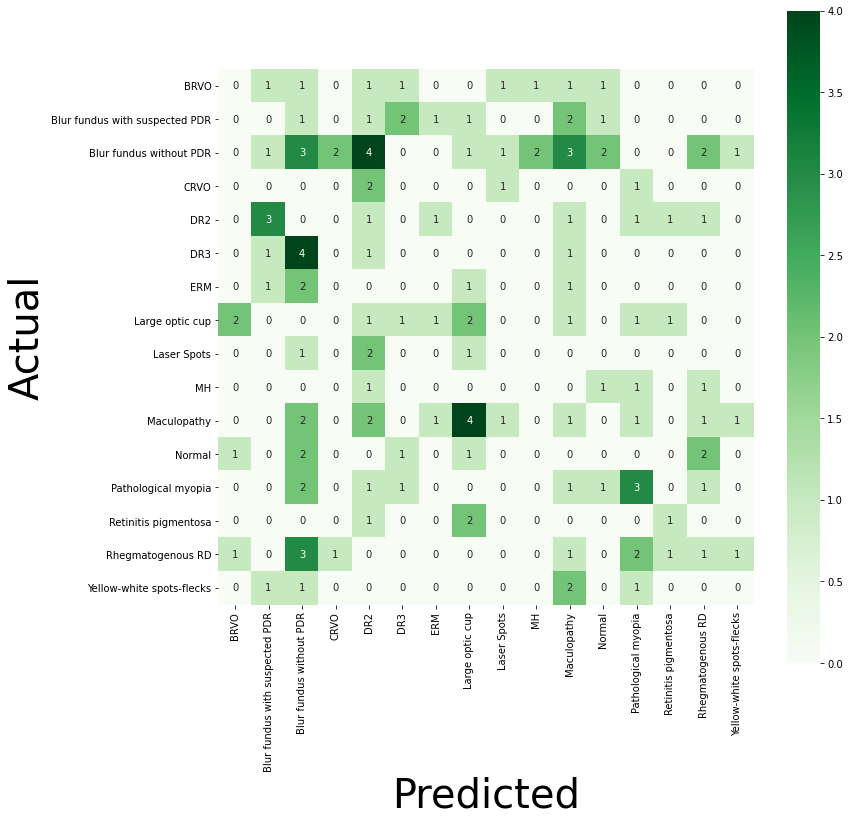

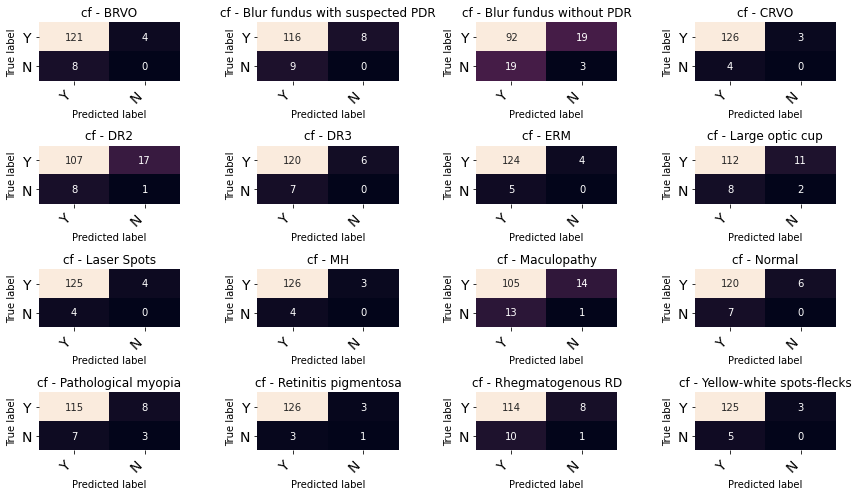

In [ ]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()


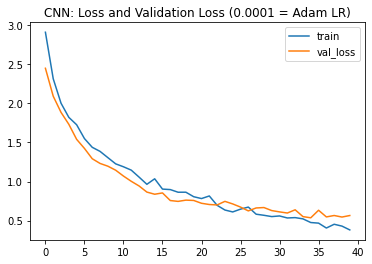

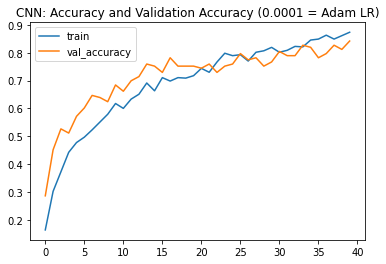

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adam LR)')
plt.legend();
plt.show()

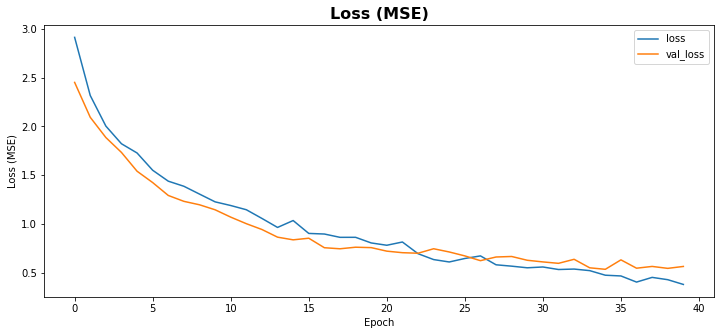

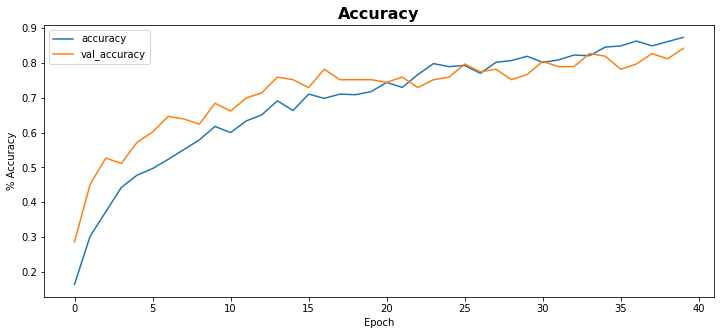

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [ ]:
def get_model_densenet():
  base_model = DenseNet121(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adamax(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]

)

Epoch 1/50
18/18 [==============================] - 91s 5s/step - loss: 2.9726 - accuracy: 0.1062 - val_loss: 2.5765 - val_accuracy: 0.1880
Epoch 2/50
18/18 [==============================] - 80s 4s/step - loss: 2.6000 - accuracy: 0.1953 - val_loss: 2.3219 - val_accuracy: 0.2632
Epoch 3/50
18/18 [==============================] - 79s 4s/step - loss: 2.4763 - accuracy: 0.2226 - val_loss: 2.1948 - val_accuracy: 0.3609
Epoch 4/50
18/18 [==============================] - 79s 4s/step - loss: 2.3120 - accuracy: 0.2677 - val_loss: 2.0346 - val_accuracy: 0.4135
Epoch 5/50
18/18 [==============================] - 80s 4s/step - loss: 2.1776 - accuracy: 0.3092 - val_loss: 1.9980 - val_accuracy: 0.4361
Epoch 6/50
18/18 [==============================] - 80s 4s/step - loss: 2.0767 - accuracy: 0.3829 - val_loss: 1.9060 - val_accuracy: 0.4361
Epoch 7/50
18/18 [==============================] - 81s 5s/step - loss: 2.0561 - accuracy: 0.3488 - val_loss: 1.7518 - val_accuracy: 0.5188
Epoch 8/50
18/18 [==

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('densenet_adamax.h5')

Test loss: 0.7305033206939697
Test Accuracy: 0.7593985199928284


Confusion Matrix
[[0 0 0 2 1 0 0 0 0 0 3 1 1 0 0 0]
 [0 2 1 0 0 1 0 0 0 0 3 0 0 0 2 0]
 [0 1 2 1 1 0 0 2 0 0 4 0 5 1 4 1]
 [0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0]
 [1 1 2 0 1 0 0 2 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 0 3 0 0 3 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 1 0 2 0]
 [0 1 1 1 1 0 0 1 1 0 0 2 0 0 1 1]
 [0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 1 0 0 1 0 0 0 0]
 [1 0 2 0 2 1 0 1 1 0 1 1 2 1 1 0]
 [1 1 2 0 0 0 0 0 0 0 2 0 0 1 0 0]
 [1 1 2 0 0 1 0 1 0 0 0 2 1 0 0 1]
 [0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0]
 [0 1 1 0 3 3 0 1 0 0 2 0 0 0 0 0]
 [0 0 3 0 1 0 0 0 0 0 0 0 0 1 0 0]]



F1 Score macro 0.041127884726216375
F1 Score micro 0.06015037593984962
F1 Score weighted 0.057306049255082606
accuracy_score  0.06015037593984962
precision_score  0.03939676916650601
recall_score  0.04347943722943723
mean_squared_error  53.2406015037594


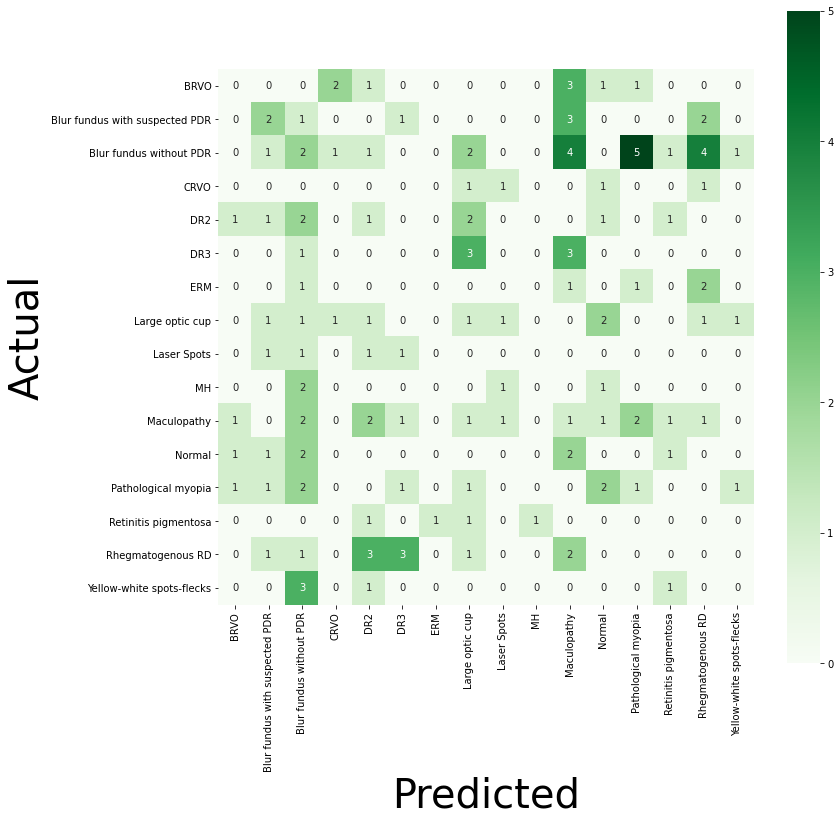

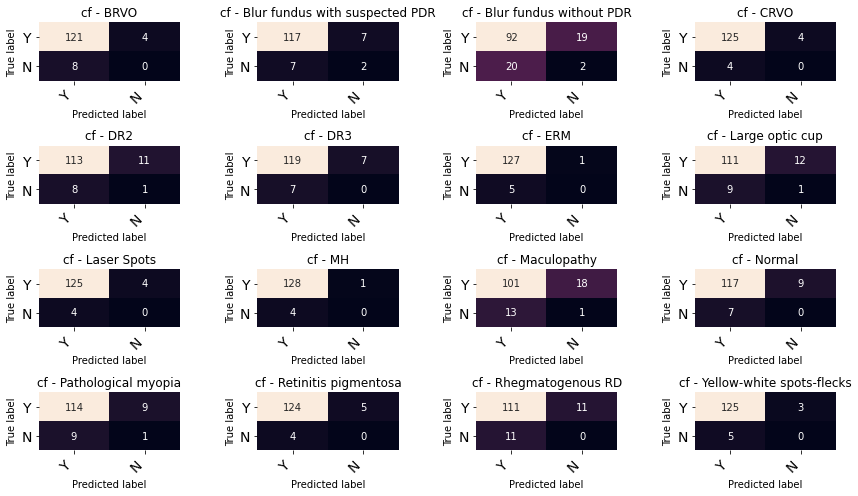

In [ ]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

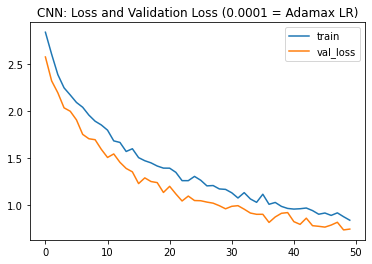

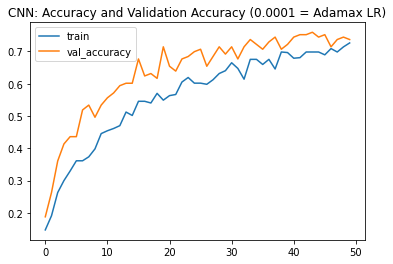

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adamax LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adamax LR)')
plt.legend();
plt.show()

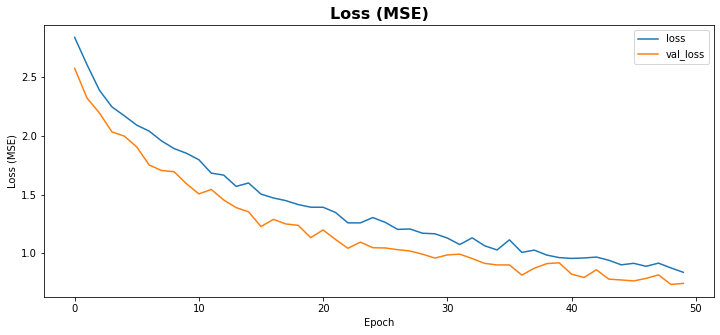

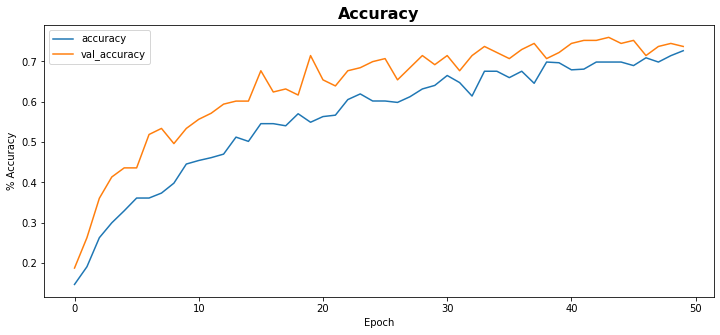

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [ ]:
def get_model_densenet():
  base_model = DenseNet121(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 90s 5s/step - loss: 2.9219 - accuracy: 0.1234 - val_loss: 2.3137 - val_accuracy: 0.2782
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 2.2484 - accuracy: 0.2880 - val_loss: 2.0174 - val_accuracy: 0.4211
Epoch 3/50
18/18 [==============================] - 78s 4s/step - loss: 2.0229 - accuracy: 0.3484 - val_loss: 1.8586 - val_accuracy: 0.4887
Epoch 4/50
18/18 [==============================] - 79s 4s/step - loss: 1.8618 - accuracy: 0.4062 - val_loss: 1.6997 - val_accuracy: 0.5188
Epoch 5/50
18/18 [==============================] - 78s 4s/step - loss: 1.6046 - accuracy: 0.5145 - val_loss: 1.5391 - val_accuracy: 0.5865
Epoch 6/50
18/18 [==============================] - 79s 4s/step - loss: 1.5606 - accuracy: 0.5242 - val_loss: 1.3643 - val_accuracy: 0.6090
Epoch 7/50
18/18 [==============================] - 78s 4s/step - loss: 1.5498 - accuracy: 0.4886 - val_loss: 1.2944 - val_accuracy: 0.6015
Epoch 8/50
18/18 [==

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('densenet_RMSprop.h5')

Test loss: 0.4377199411392212
Test Accuracy: 0.8721804618835449


Confusion Matrix
[[0 2 0 0 1 0 0 0 0 0 2 2 1 0 0 0]
 [0 1 0 0 1 3 0 0 1 0 0 0 1 0 1 1]
 [4 2 4 0 0 1 1 3 1 1 1 0 2 0 1 1]
 [0 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 2 0 1 0 1 0 1 0 1 1 1 0]
 [0 0 2 0 0 0 0 1 0 0 1 2 1 0 0 0]
 [1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0]
 [0 2 2 0 2 0 1 1 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0]
 [1 0 4 1 0 0 0 2 0 1 1 2 1 1 0 0]
 [1 0 0 0 1 0 1 0 0 0 3 0 1 0 0 0]
 [0 0 4 0 0 0 0 0 1 0 1 0 0 2 2 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 2 0]
 [1 0 1 1 2 1 2 1 0 0 1 0 1 0 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 0 0 2 0]]



F1 Score macro 0.041633244206773626
F1 Score micro 0.06766917293233082
F1 Score weighted 0.06624965775783999
accuracy_score  0.06766917293233082
precision_score  0.040685876623376624
recall_score  0.042911255411255414
mean_squared_error  41.796992481203006


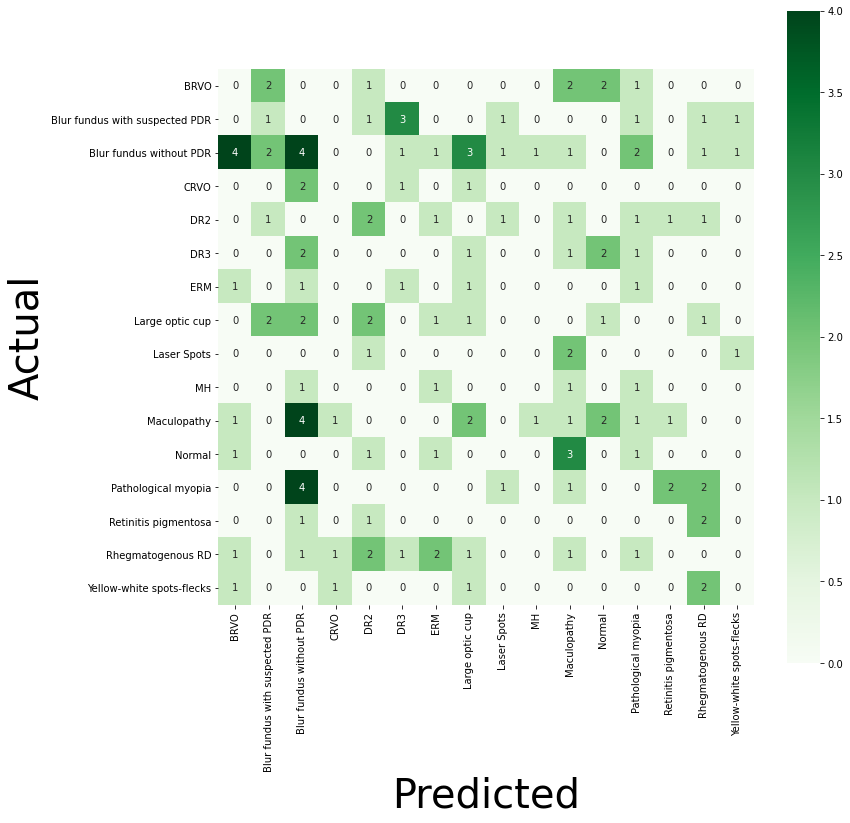

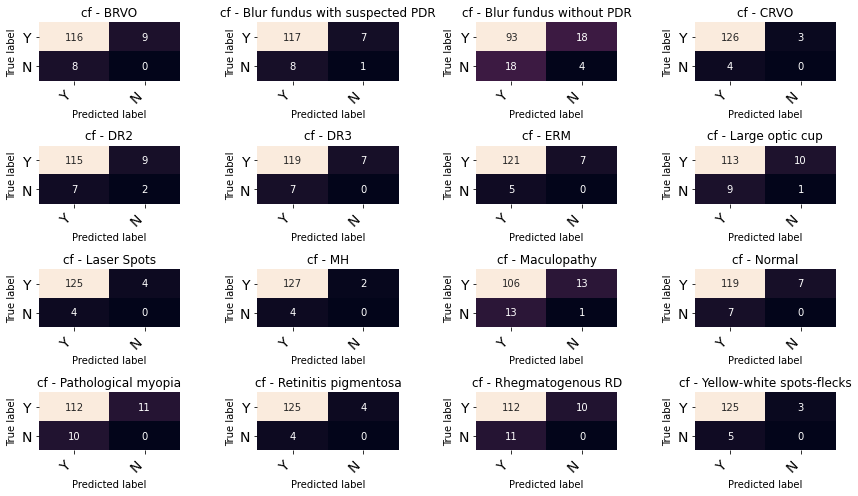

In [ ]:
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)


print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

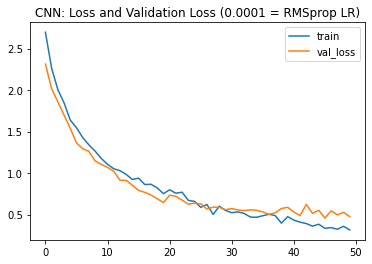

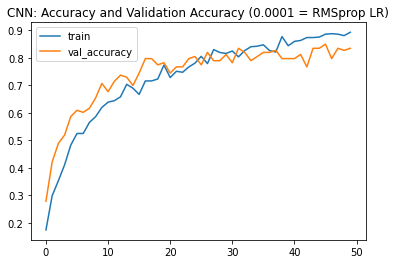

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = RMSprop LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = RMSprop LR)')
plt.legend();
plt.show()

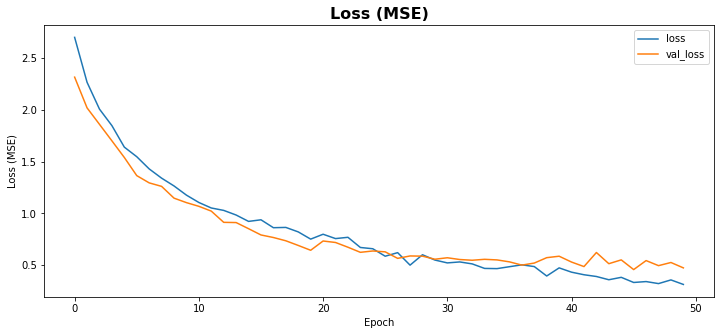

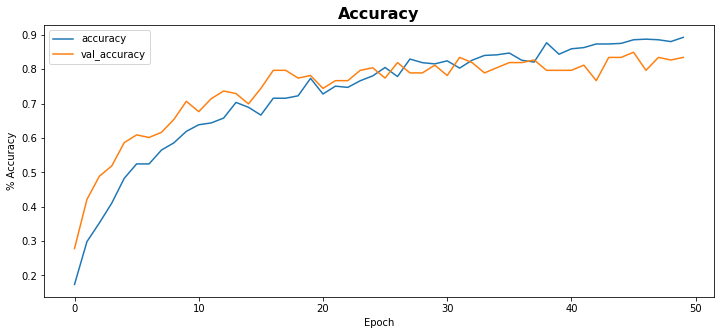

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [ ]:
def get_model_densenet():
  base_model = DenseNet121(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)


Epoch 1/50
18/18 [==============================] - 88s 5s/step - loss: 3.3167 - accuracy: 0.0762 - val_loss: 2.8459 - val_accuracy: 0.0752
Epoch 2/50
18/18 [==============================] - 77s 4s/step - loss: 3.0448 - accuracy: 0.1050 - val_loss: 2.6512 - val_accuracy: 0.1429
Epoch 3/50
18/18 [==============================] - 77s 4s/step - loss: 2.8200 - accuracy: 0.1395 - val_loss: 2.6029 - val_accuracy: 0.1805
Epoch 4/50
18/18 [==============================] - 78s 4s/step - loss: 2.8094 - accuracy: 0.1682 - val_loss: 2.5318 - val_accuracy: 0.2105
Epoch 5/50
18/18 [==============================] - 78s 4s/step - loss: 2.7358 - accuracy: 0.1645 - val_loss: 2.4544 - val_accuracy: 0.2707
Epoch 6/50
18/18 [==============================] - 78s 4s/step - loss: 2.5888 - accuracy: 0.2142 - val_loss: 2.3567 - val_accuracy: 0.2932
Epoch 7/50
18/18 [==============================] - 78s 4s/step - loss: 2.5596 - accuracy: 0.2428 - val_loss: 2.3516 - val_accuracy: 0.3083
Epoch 8/50
18/18 [==

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('densenet_SGD.h5')

Test loss: 1.516729474067688
Test Accuracy: 0.5263158082962036


Confusion Matrix
[[0 2 0 1 1 0 0 1 0 0 1 1 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0 3 0 2 0 2 0]
 [2 0 5 0 2 0 0 0 0 0 6 2 4 0 1 0]
 [0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 2 2 0 0 1 0 1 0 0 2 0 1 0 0 0]
 [0 1 2 1 2 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 3 0 0 1 0 0 0 0 0]
 [0 0 1 0 2 0 0 5 0 0 1 0 1 0 0 0]
 [0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 2 4 0 3 0 0 0 0 0 3 0 1 0 1 0]
 [0 0 2 0 0 1 0 2 0 0 2 0 0 0 0 0]
 [2 0 1 0 0 0 0 1 0 0 2 1 3 0 0 0]
 [1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 0 2 0 0 1 1 1 0 2 0]
 [0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0]]



F1 Score macro 0.08923350041771094
F1 Score micro 0.14285714285714285
F1 Score weighted 0.12230136745372203
accuracy_score  0.14285714285714285
precision_score  0.08027842477570737
recall_score  0.10458603896103896
mean_squared_error  46.46616541353384


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



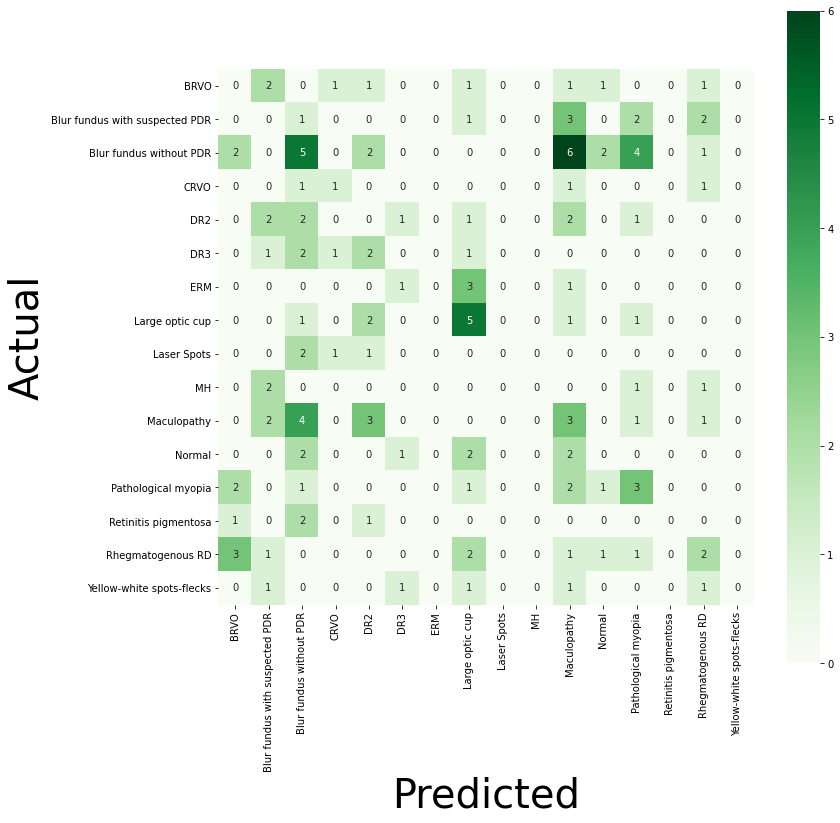

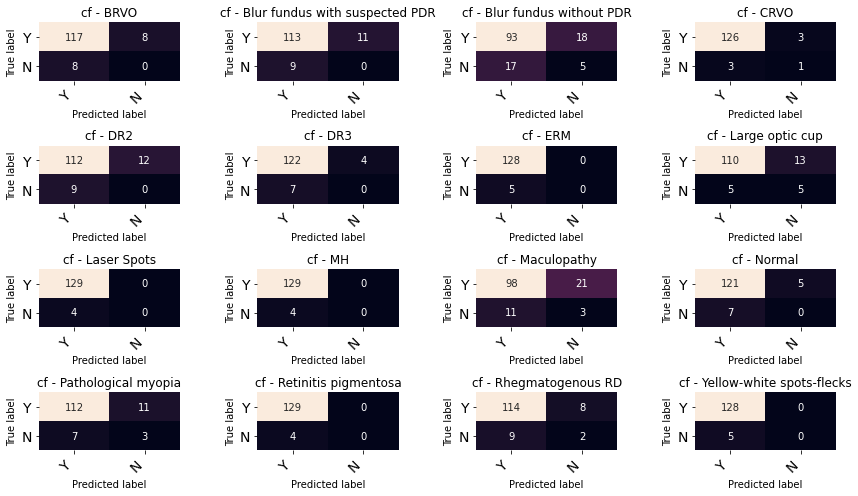

In [ ]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

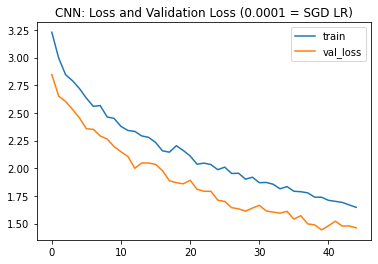

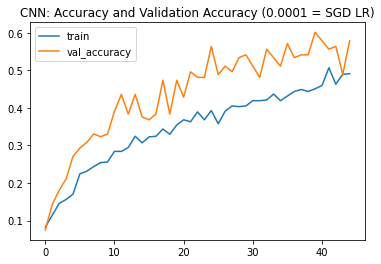

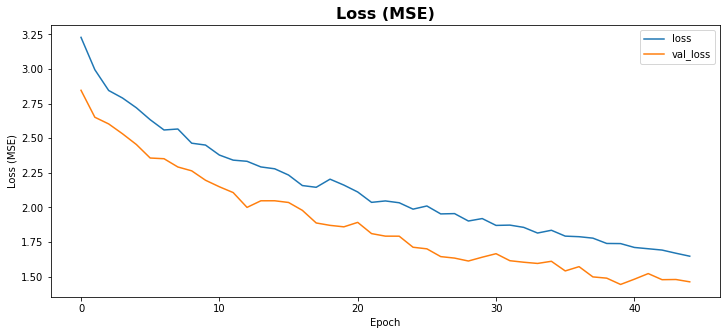

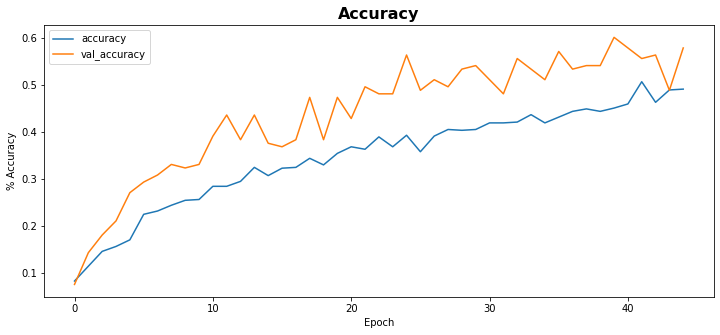

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = SGD LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = SGD LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [ ]:
def get_model_densenet():
  base_model = DenseNet121(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 88s 5s/step - loss: 2.9703 - accuracy: 0.1774 - val_loss: 1.8049 - val_accuracy: 0.3910
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 1.5674 - accuracy: 0.5059 - val_loss: 1.3045 - val_accuracy: 0.5714
Epoch 3/50
18/18 [==============================] - 79s 4s/step - loss: 1.1363 - accuracy: 0.6054 - val_loss: 1.2745 - val_accuracy: 0.5639
Epoch 4/50
18/18 [==============================] - 79s 4s/step - loss: 0.9620 - accuracy: 0.6615 - val_loss: 1.3490 - val_accuracy: 0.5564
Epoch 5/50
18/18 [==============================] - 79s 4s/step - loss: 0.8802 - accuracy: 0.6956 - val_loss: 1.1066 - val_accuracy: 0.6015
Epoch 6/50
18/18 [==============================] - 79s 4s/step - loss: 0.8670 - accuracy: 0.7005 - val_loss: 0.7400 - val_accuracy: 0.7895
Epoch 7/50
18/18 [==============================] - 79s 4s/step - loss: 0.7036 - accuracy: 0.7488 - val_loss: 0.8623 - val_accuracy: 0.7368
Epoch 8/50
18/18 [==

In [ ]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('densenet_adam.h5')


Test loss: 0.6103576421737671
Test Accuracy: 0.7894737124443054


Confusion Matrix
[[0 0 1 0 0 1 0 0 0 0 1 0 3 1 1 0]
 [0 2 0 0 0 0 0 2 2 1 1 0 0 0 1 0]
 [1 1 5 2 1 1 0 1 1 0 3 1 1 0 2 2]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1]
 [2 0 1 1 0 1 0 0 0 0 0 2 0 1 1 0]
 [1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0]
 [1 0 1 0 0 0 0 1 0 0 0 0 0 2 0 0]
 [0 2 1 0 0 1 1 1 0 1 3 0 0 0 0 0]
 [0 0 0 0 1 0 2 0 0 0 1 0 0 0 0 0]
 [0 0 2 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [1 0 2 0 0 0 1 1 2 0 3 0 1 1 1 1]
 [1 0 1 0 1 0 0 0 0 0 2 1 1 0 0 0]
 [1 0 4 0 1 0 0 1 0 0 1 0 0 0 2 0]
 [0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0]
 [1 1 1 0 1 0 1 3 0 0 0 1 0 0 2 0]
 [0 1 0 0 1 1 0 0 0 0 0 0 0 0 2 0]]



F1 Score macro 0.07596654029964563
F1 Score micro 0.11278195488721804
F1 Score weighted 0.11112736928274405
accuracy_score  0.11278195488721804
precision_score  0.07570684523809523
recall_score  0.07695707070707071
mean_squared_error  46.97744360902256


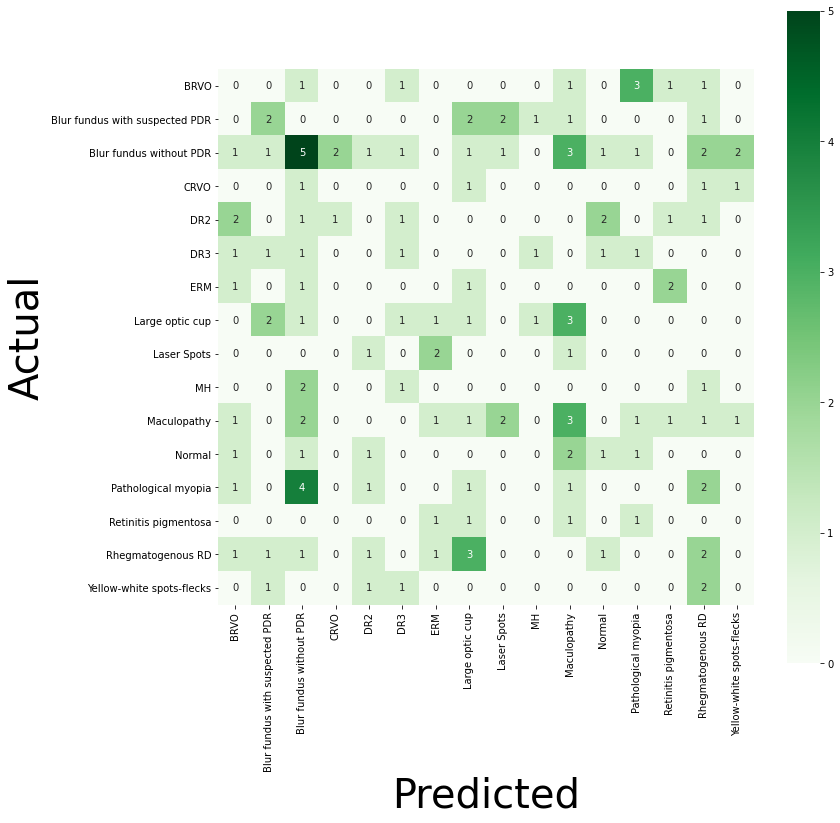

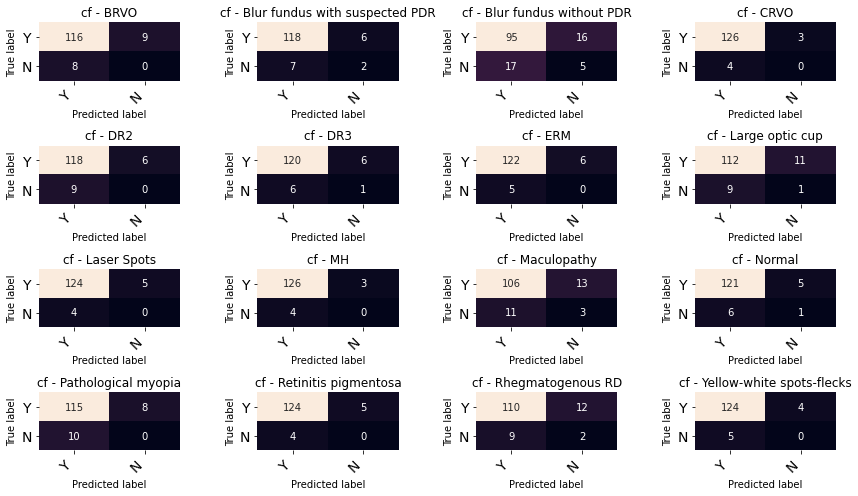

In [ ]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()


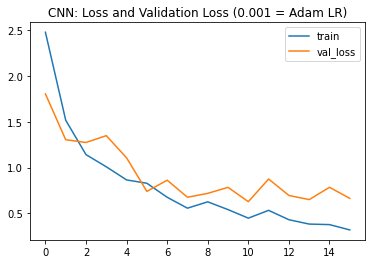

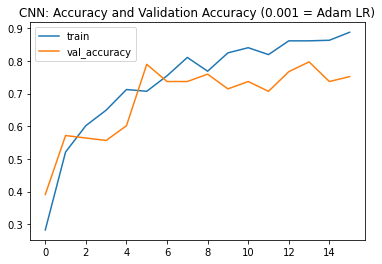

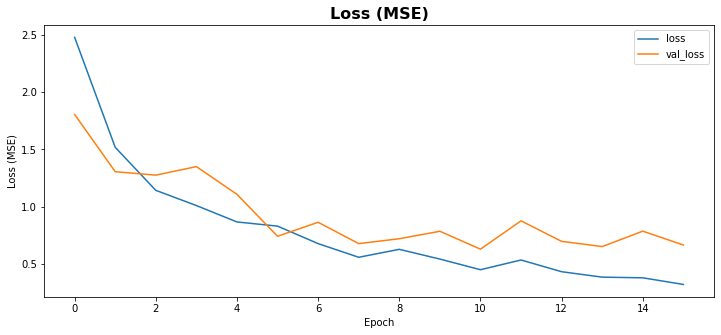

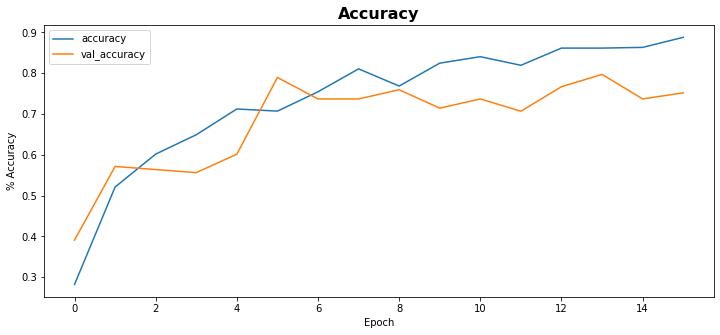

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.001 = Adam LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [ ]:
def get_model_densenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 89s 5s/step - loss: 2.8195 - accuracy: 0.1236 - val_loss: 2.0917 - val_accuracy: 0.3609
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 2.1248 - accuracy: 0.3452 - val_loss: 1.6512 - val_accuracy: 0.5338
Epoch 3/50
18/18 [==============================] - 80s 4s/step - loss: 1.6842 - accuracy: 0.5052 - val_loss: 1.4219 - val_accuracy: 0.5639
Epoch 4/50
18/18 [==============================] - 80s 4s/step - loss: 1.4558 - accuracy: 0.5868 - val_loss: 1.2308 - val_accuracy: 0.6165
Epoch 5/50
18/18 [==============================] - 80s 4s/step - loss: 1.1420 - accuracy: 0.6746 - val_loss: 1.1754 - val_accuracy: 0.6241
Epoch 6/50
18/18 [==============================] - 80s 5s/step - loss: 1.0181 - accuracy: 0.7267 - val_loss: 1.0545 - val_accuracy: 0.6316
Epoch 7/50
18/18 [==============================] - 80s 4s/step - loss: 0.9542 - accuracy: 0.7023 - val_loss: 0.9822 - val_accuracy: 0.6842
Epoch 8/50
18/18 [==

Test loss: 0.5822427868843079
Test Accuracy: 0.7894737124443054
Confusion Matrix
[[0 1 2 0 1 0 0 1 0 0 1 1 0 0 1 0]
 [1 2 1 0 1 0 0 2 0 1 0 0 0 0 0 1]
 [0 2 2 1 1 1 0 0 1 0 5 1 3 1 1 3]
 [0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 1 2 0 0 1 1 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 2 0 2 0]
 [2 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 2 0 2 0 0 1 0 0 2 0 2 0 0 1]
 [0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 1 1 2 1 2 1 1 1 0 1 0 0 1 0 1]
 [0 0 2 0 0 0 0 1 0 0 1 0 2 0 1 0]
 [2 0 0 0 1 0 2 3 0 0 0 0 0 0 2 0]
 [1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 1 2 0 1 1 1 0 1 0 1 0 0]
 [0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0]]



F1 Score macro 0.029553858807224782
F1 Score micro 0.045112781954887216
F1 Score weighted 0.04459147713857315
accuracy_score  0.045112781954887216
precision_score  0.028941891441891444
recall_score  0.030284992784992783
mean_squared_error  48.30827067669173


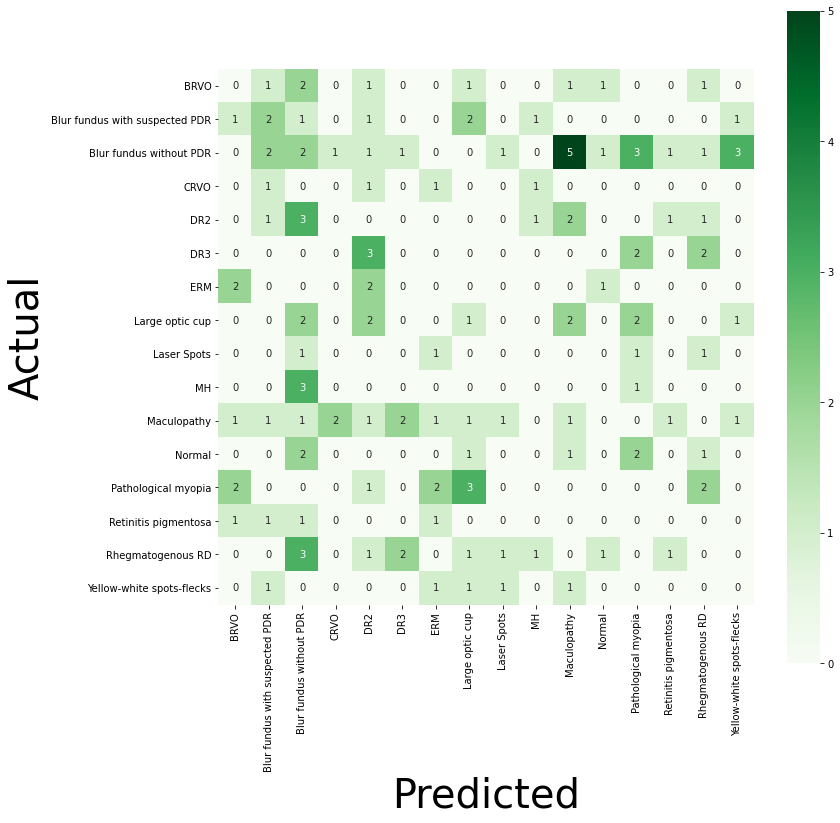

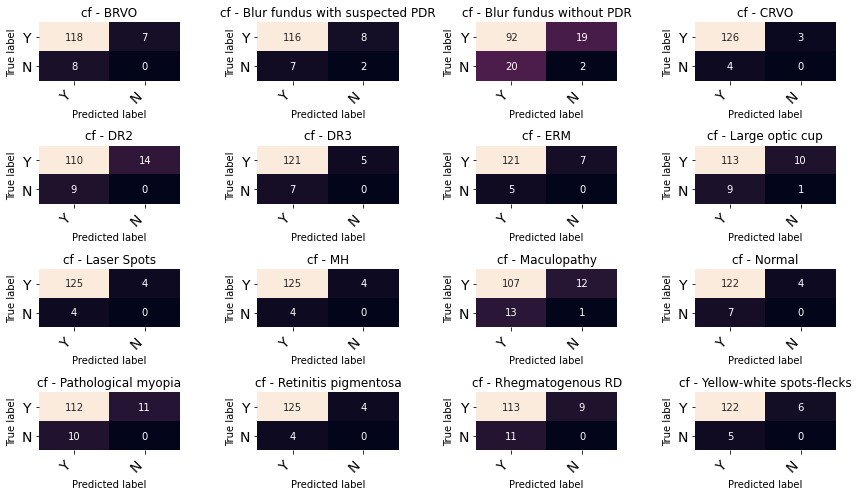

In [ ]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

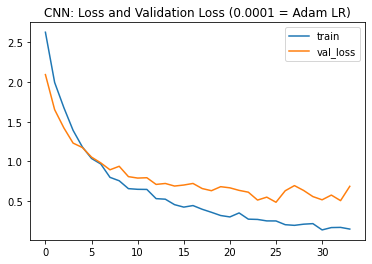

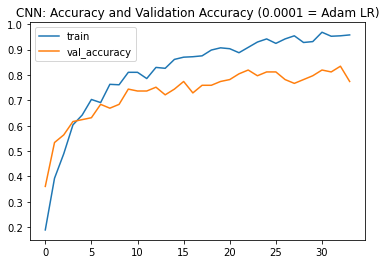

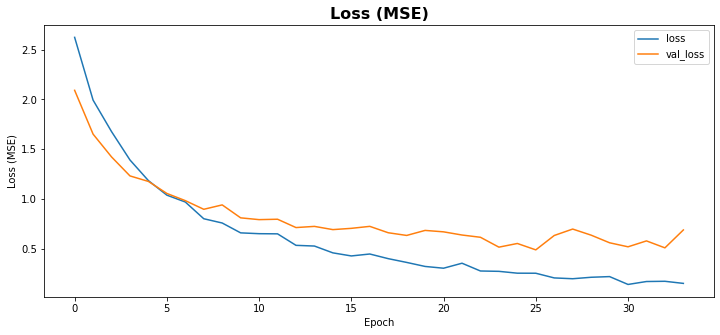

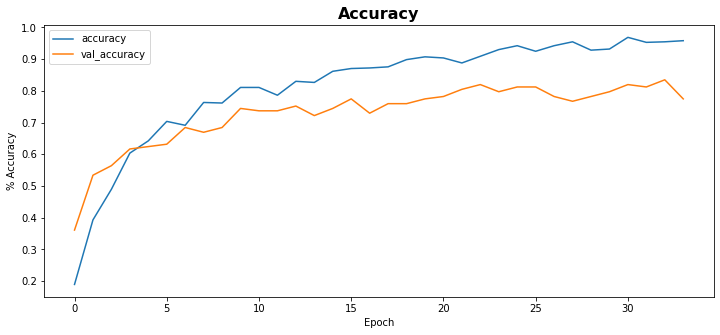

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adam LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [ ]:
def get_model_densenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adamax(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 313s 17s/step - loss: 2.9596 - accuracy: 0.0847 - val_loss: 2.2774 - val_accuracy: 0.3459
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 2.2990 - accuracy: 0.3153 - val_loss: 2.0923 - val_accuracy: 0.3308
Epoch 3/50
18/18 [==============================] - 80s 5s/step - loss: 2.1707 - accuracy: 0.3498 - val_loss: 1.9097 - val_accuracy: 0.4511
Epoch 4/50
18/18 [==============================] - 79s 4s/step - loss: 1.9757 - accuracy: 0.4171 - val_loss: 1.7360 - val_accuracy: 0.4662
Epoch 5/50
18/18 [==============================] - 79s 4s/step - loss: 1.9546 - accuracy: 0.4192 - val_loss: 1.6576 - val_accuracy: 0.5038
Epoch 6/50
18/18 [==============================] - 79s 4s/step - loss: 1.7186 - accuracy: 0.4829 - val_loss: 1.5886 - val_accuracy: 0.5489
Epoch 7/50
18/18 [==============================] - 79s 4s/step - loss: 1.5959 - accuracy: 0.5323 - val_loss: 1.5263 - val_accuracy: 0.5038
Epoch 8/50
18/18 [

Test loss: 0.6200006008148193
Test Accuracy: 0.7969924807548523
Confusion Matrix
[[0 1 0 0 1 0 0 0 1 0 2 1 1 0 0 1]
 [1 1 1 0 0 1 1 2 0 0 1 0 0 1 0 0]
 [0 3 2 2 1 0 0 3 0 3 2 1 1 0 2 2]
 [0 0 2 1 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 3 0 0 0 0 1 0 0 3 0 1 0 0 0]
 [0 0 2 0 0 1 0 0 0 0 0 2 2 0 0 0]
 [0 0 3 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 1 0 0 1 0 2 3 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0]
 [0 1 1 0 3 1 2 1 0 0 1 1 1 2 0 0]
 [0 0 0 0 2 0 1 1 0 0 0 0 0 0 3 0]
 [1 1 2 0 1 1 0 0 0 0 1 0 1 0 1 1]
 [0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0]
 [0 2 1 1 1 2 0 0 0 0 1 0 2 0 1 0]
 [1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0]]



F1 Score macro 0.05344518650495035
F1 Score micro 0.06015037593984962
F1 Score weighted 0.06059569267553817
accuracy_score  0.06015037593984962
precision_score  0.053481003645477324
recall_score  0.053575937950937944
mean_squared_error  44.42857142857143


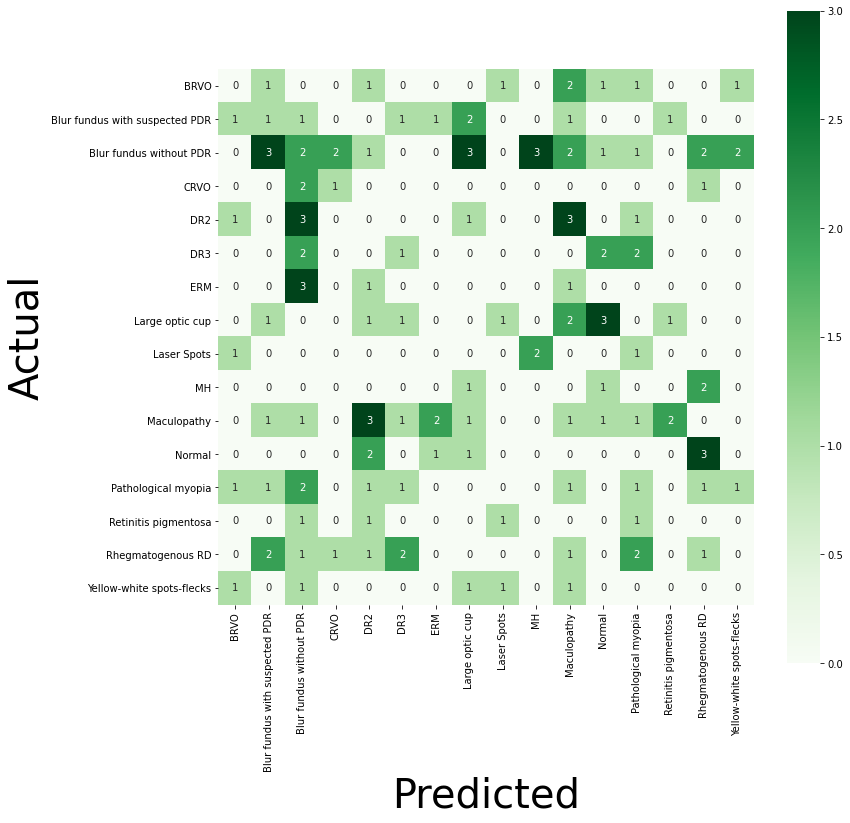

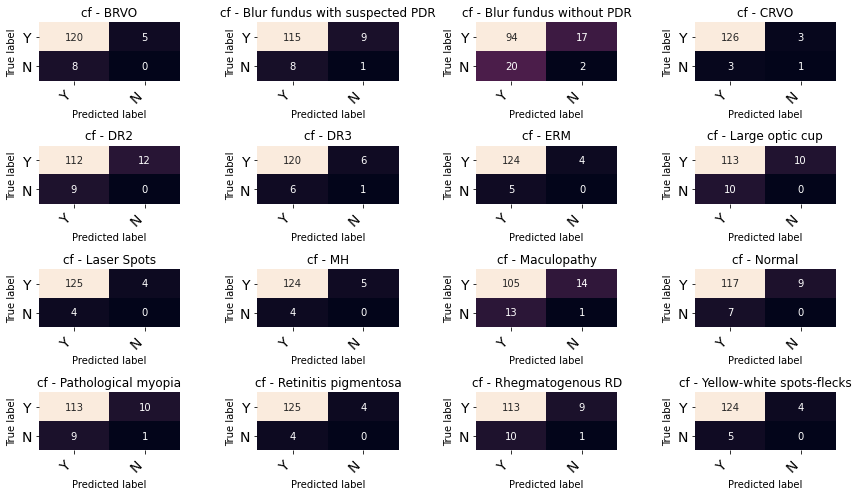

In [ ]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adamax LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adamax LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [26]:
def get_model_densenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [27]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 88s 5s/step - loss: 2.6465 - accuracy: 0.1938 - val_loss: 1.9095 - val_accuracy: 0.3534
Epoch 2/50
18/18 [==============================] - 78s 4s/step - loss: 1.9329 - accuracy: 0.4295 - val_loss: 1.5601 - val_accuracy: 0.5188
Epoch 3/50
18/18 [==============================] - 78s 4s/step - loss: 1.5880 - accuracy: 0.5009 - val_loss: 1.3568 - val_accuracy: 0.5564
Epoch 4/50
18/18 [==============================] - 78s 4s/step - loss: 1.3283 - accuracy: 0.5886 - val_loss: 1.1977 - val_accuracy: 0.5865
Epoch 5/50
18/18 [==============================] - 77s 4s/step - loss: 1.1491 - accuracy: 0.6618 - val_loss: 1.1954 - val_accuracy: 0.5414
Epoch 6/50
18/18 [==============================] - 77s 4s/step - loss: 1.1282 - accuracy: 0.6499 - val_loss: 1.0147 - val_accuracy: 0.6917
Epoch 7/50
18/18 [==============================] - 77s 4s/step - loss: 0.8989 - accuracy: 0.7356 - val_loss: 0.9858 - val_accuracy: 0.7143
Epoch 8/50
18/18 [==

Test loss: 0.5665035247802734
Test Accuracy: 0.8045112490653992
Confusion Matrix
[[0 1 2 1 1 1 0 0 0 0 0 1 0 0 1 0]
 [0 1 2 1 1 0 0 0 1 0 1 0 0 0 1 1]
 [3 1 3 0 1 1 0 1 2 0 4 1 2 1 1 1]
 [0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 2 0 0 0 0 1 0 0 1 0 1 0 2 2]
 [0 0 0 0 0 1 1 1 0 0 2 1 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0]
 [0 1 3 0 1 0 2 1 0 0 1 0 0 0 1 0]
 [1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 1 2 0 3 1 0 1 0 0 2 1 1 1 0 1]
 [0 1 1 0 1 0 0 1 0 0 0 0 1 0 2 0]
 [0 0 1 1 1 0 2 1 0 0 1 1 0 1 0 1]
 [0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0]
 [0 0 3 1 0 1 1 0 0 1 1 1 2 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 2 1 0 0 0]]



F1 Score macro 0.058547832945318797
F1 Score micro 0.06766917293233082
F1 Score weighted 0.06964112639772911
accuracy_score  0.06766917293233082
precision_score  0.06286300505050504
recall_score  0.055199314574314574
mean_squared_error  41.78195488721804


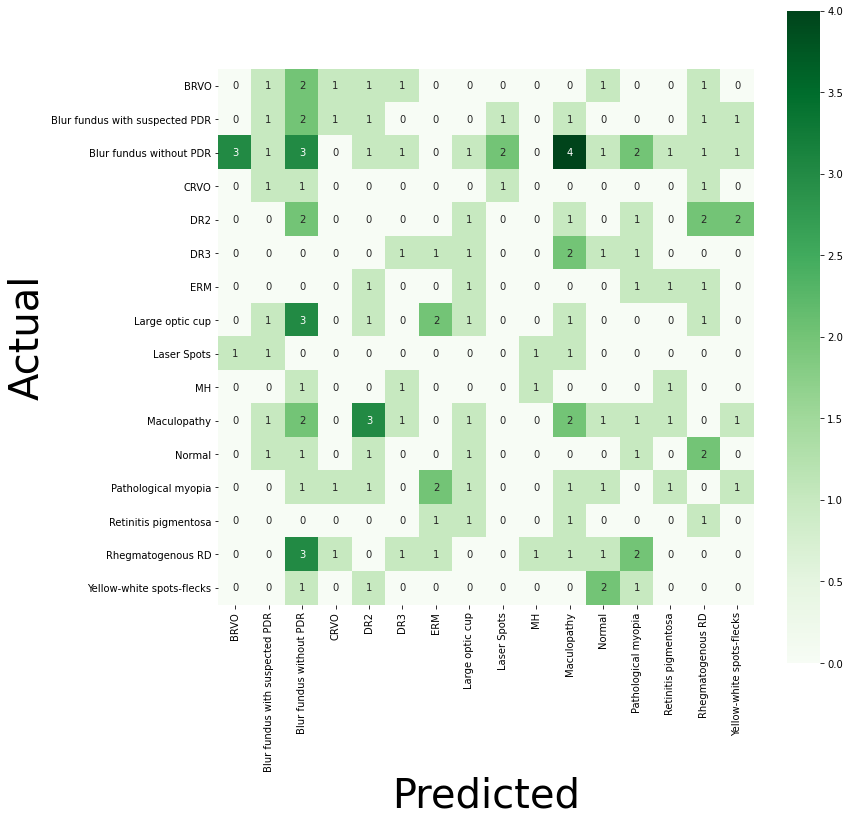

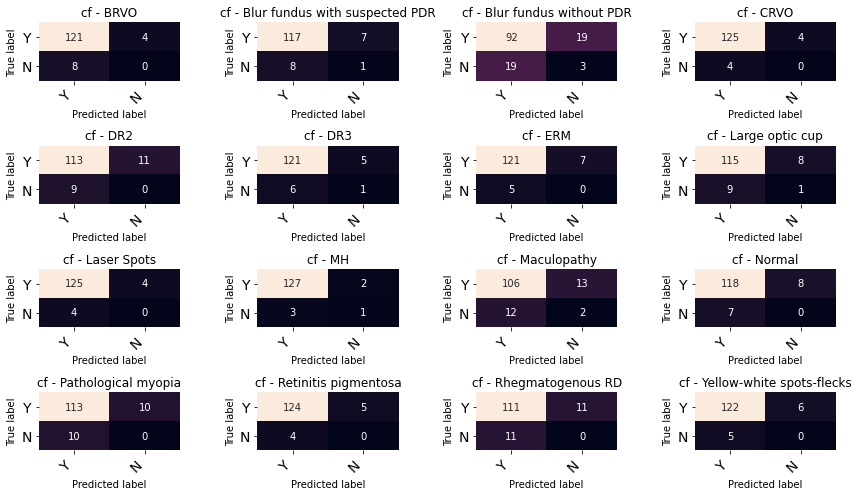

In [38]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

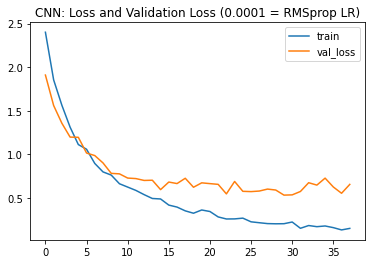

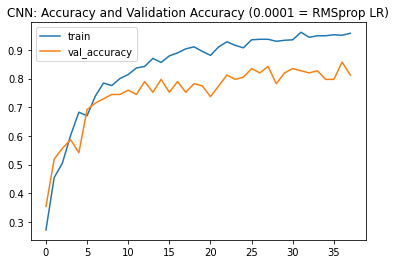

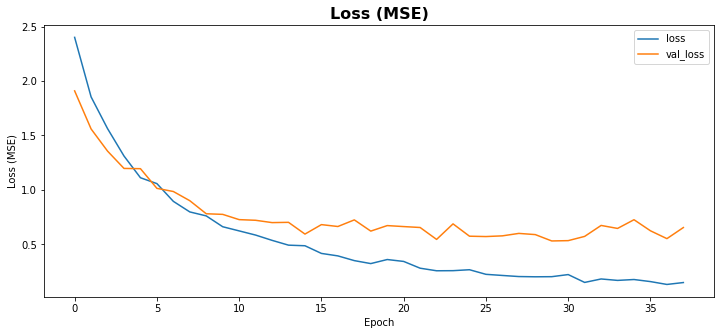

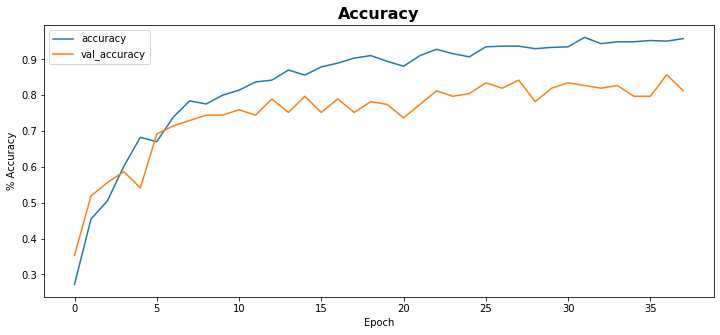

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = RMSprop LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = RMSprop LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro',labels=Diseases))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1,normalize=False))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro',labels=Diseases))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ",  mean_squared_error(val_generator.classes))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))

F1 Score macro 0.0
F1 Score micro 0.09022556390977443
F1 Score weighted 0.09256149887601427
accuracy_score  12
precision_score  0.0
recall_score  0.06940386002886004


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



TypeError: ignored

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print(classification_report(val_generator.classes, y_pred1,target_names=Diseases))

                                precision    recall  f1-score   support

                          BRVO       0.00      0.00      0.00         8
Blur fundus with suspected PDR       0.12      0.11      0.12         9
       Blur fundus without PDR       0.19      0.18      0.19        22
                          CRVO       0.25      0.25      0.25         4
                           DR2       0.00      0.00      0.00         9
                           DR3       0.00      0.00      0.00         7
                           ERM       0.00      0.00      0.00         5
               Large optic cup       0.00      0.00      0.00        10
                   Laser Spots       0.00      0.00      0.00         4
                            MH       0.00      0.00      0.00         4
                   Maculopathy       0.12      0.14      0.13        14
                        Normal       0.33      0.14      0.20         7
           Pathological myopia       0.09      0.10      0.10  

In [39]:
df_cm

NameError: ignored

In [13]:
def get_model_densenet():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.3)(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_densenet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [14]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 292s 16s/step - loss: 3.7241 - accuracy: 0.2611 - val_loss: 2.3331 - val_accuracy: 0.4737
Epoch 2/50
18/18 [==============================] - 83s 5s/step - loss: 1.3480 - accuracy: 0.5868 - val_loss: 1.9585 - val_accuracy: 0.5489
Epoch 3/50
18/18 [==============================] - 82s 5s/step - loss: 1.0441 - accuracy: 0.6577 - val_loss: 1.4212 - val_accuracy: 0.6917
Epoch 4/50
18/18 [==============================] - 82s 5s/step - loss: 0.8063 - accuracy: 0.7352 - val_loss: 2.1141 - val_accuracy: 0.6617
Epoch 5/50
18/18 [==============================] - 81s 5s/step - loss: 0.7009 - accuracy: 0.7932 - val_loss: 1.9518 - val_accuracy: 0.7068
Epoch 6/50
18/18 [==============================] - 80s 4s/step - loss: 0.5500 - accuracy: 0.8218 - val_loss: 1.7798 - val_accuracy: 0.7218
Epoch 7/50
18/18 [==============================] - 81s 5s/step - loss: 0.5856 - accuracy: 0.8173 - val_loss: 3.5786 - val_accuracy: 0.6466
Epoch 8/50
18/18 [

Test loss: 1.2920862436294556
Test Accuracy: 0.6842105388641357
Confusion Matrix
[[0 0 0 0 2 1 1 0 0 0 1 1 1 1 0 0]
 [0 2 0 0 0 2 1 2 0 0 1 0 0 0 1 0]
 [3 2 2 0 0 1 3 2 1 0 2 0 2 0 3 1]
 [0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0]
 [0 1 3 0 0 0 0 1 0 0 2 0 0 0 2 0]
 [1 1 1 0 0 0 1 0 0 0 0 0 2 0 1 0]
 [0 0 1 0 0 0 1 1 0 0 2 0 0 0 0 0]
 [0 1 1 0 0 2 2 1 0 0 0 0 1 1 1 0]
 [0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0]
 [1 1 2 0 1 3 0 1 0 1 2 1 0 0 1 0]
 [0 0 1 2 0 0 0 0 0 0 0 0 1 0 2 1]
 [0 0 2 0 0 0 1 1 0 0 2 1 1 0 2 0]
 [0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0]
 [0 0 2 0 0 1 1 1 0 0 2 2 0 0 2 0]
 [0 0 0 0 0 0 1 0 2 0 0 1 1 0 0 0]]



F1 Score macro 0.05648151709196264
F1 Score micro 0.08270676691729323
F1 Score weighted 0.07632799476529138
accuracy_score  0.08270676691729323
precision_score  0.05325686364289306
recall_score  0.06486291486291486
mean_squared_error  37.29323308270677


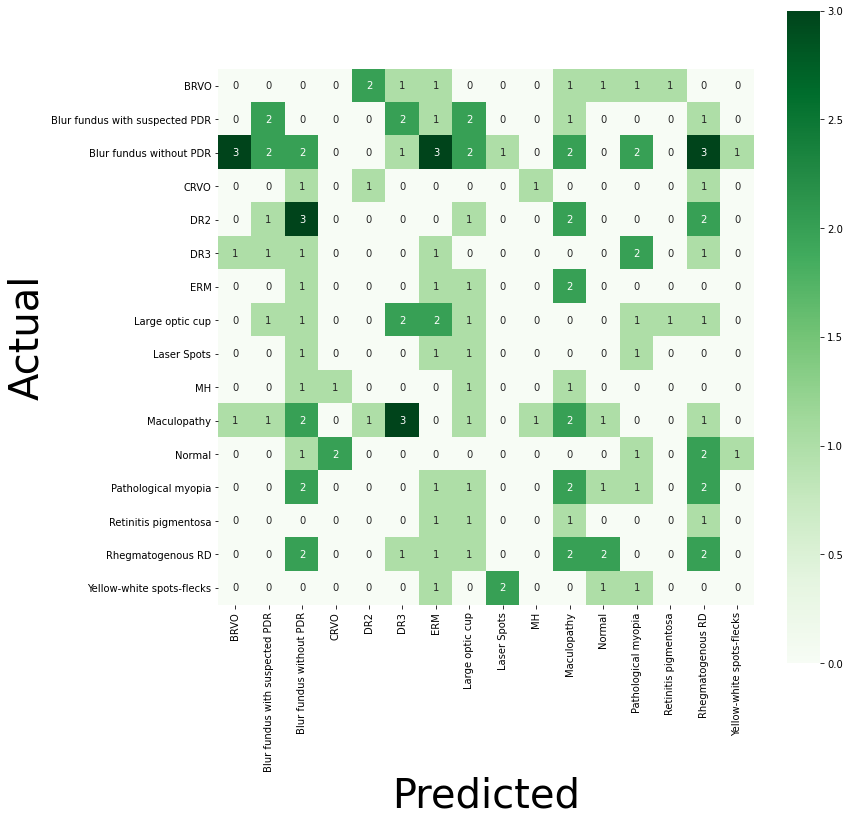

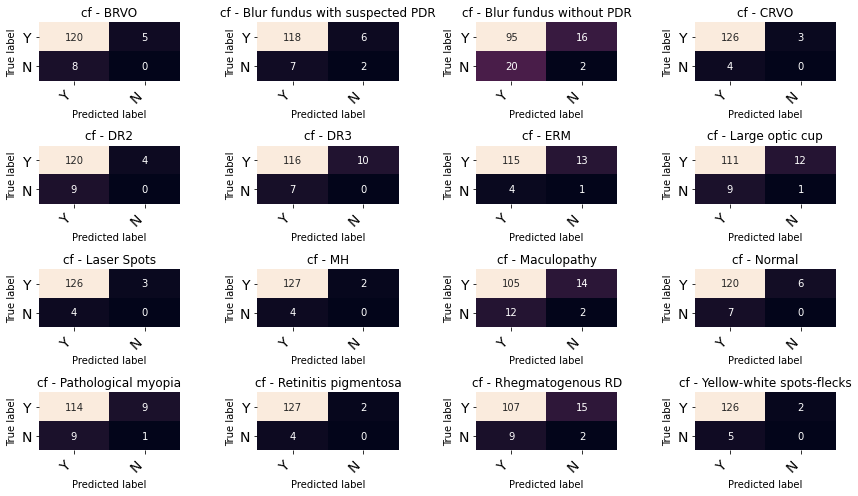

In [15]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

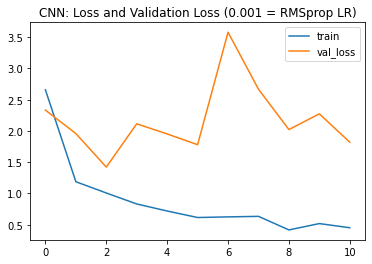

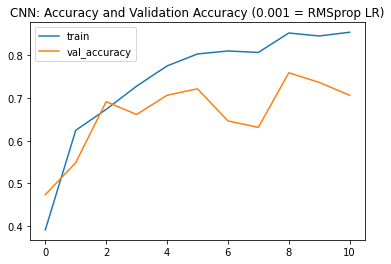

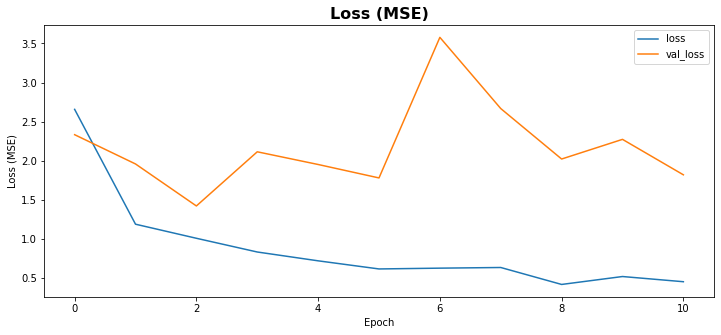

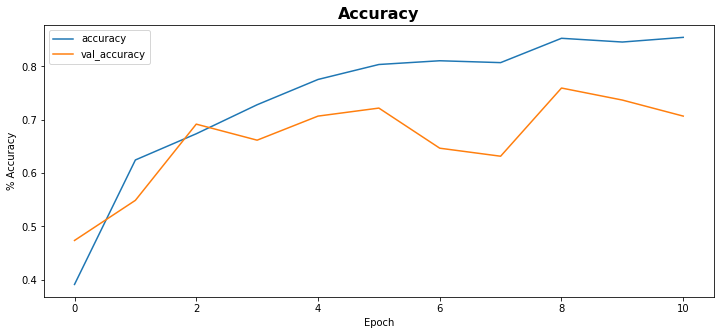

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.001 = RMSprop LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.001 = RMSprop LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()